In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [20]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models for Regression
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_squared_log_error,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Other machine learning libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Preprocessing and pipelines
from sklearn.pipeline import make_pipeline , Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

In [5]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.00,82.00,26.00,101.00,41.00,150.00
1,1,female,64,163.00,60.00,8.00,85.00,39.70,34.00
2,2,female,51,161.00,64.00,7.00,84.00,39.80,29.00
3,3,male,20,192.00,90.00,25.00,105.00,40.70,140.00
4,4,female,38,166.00,61.00,25.00,102.00,40.60,146.00


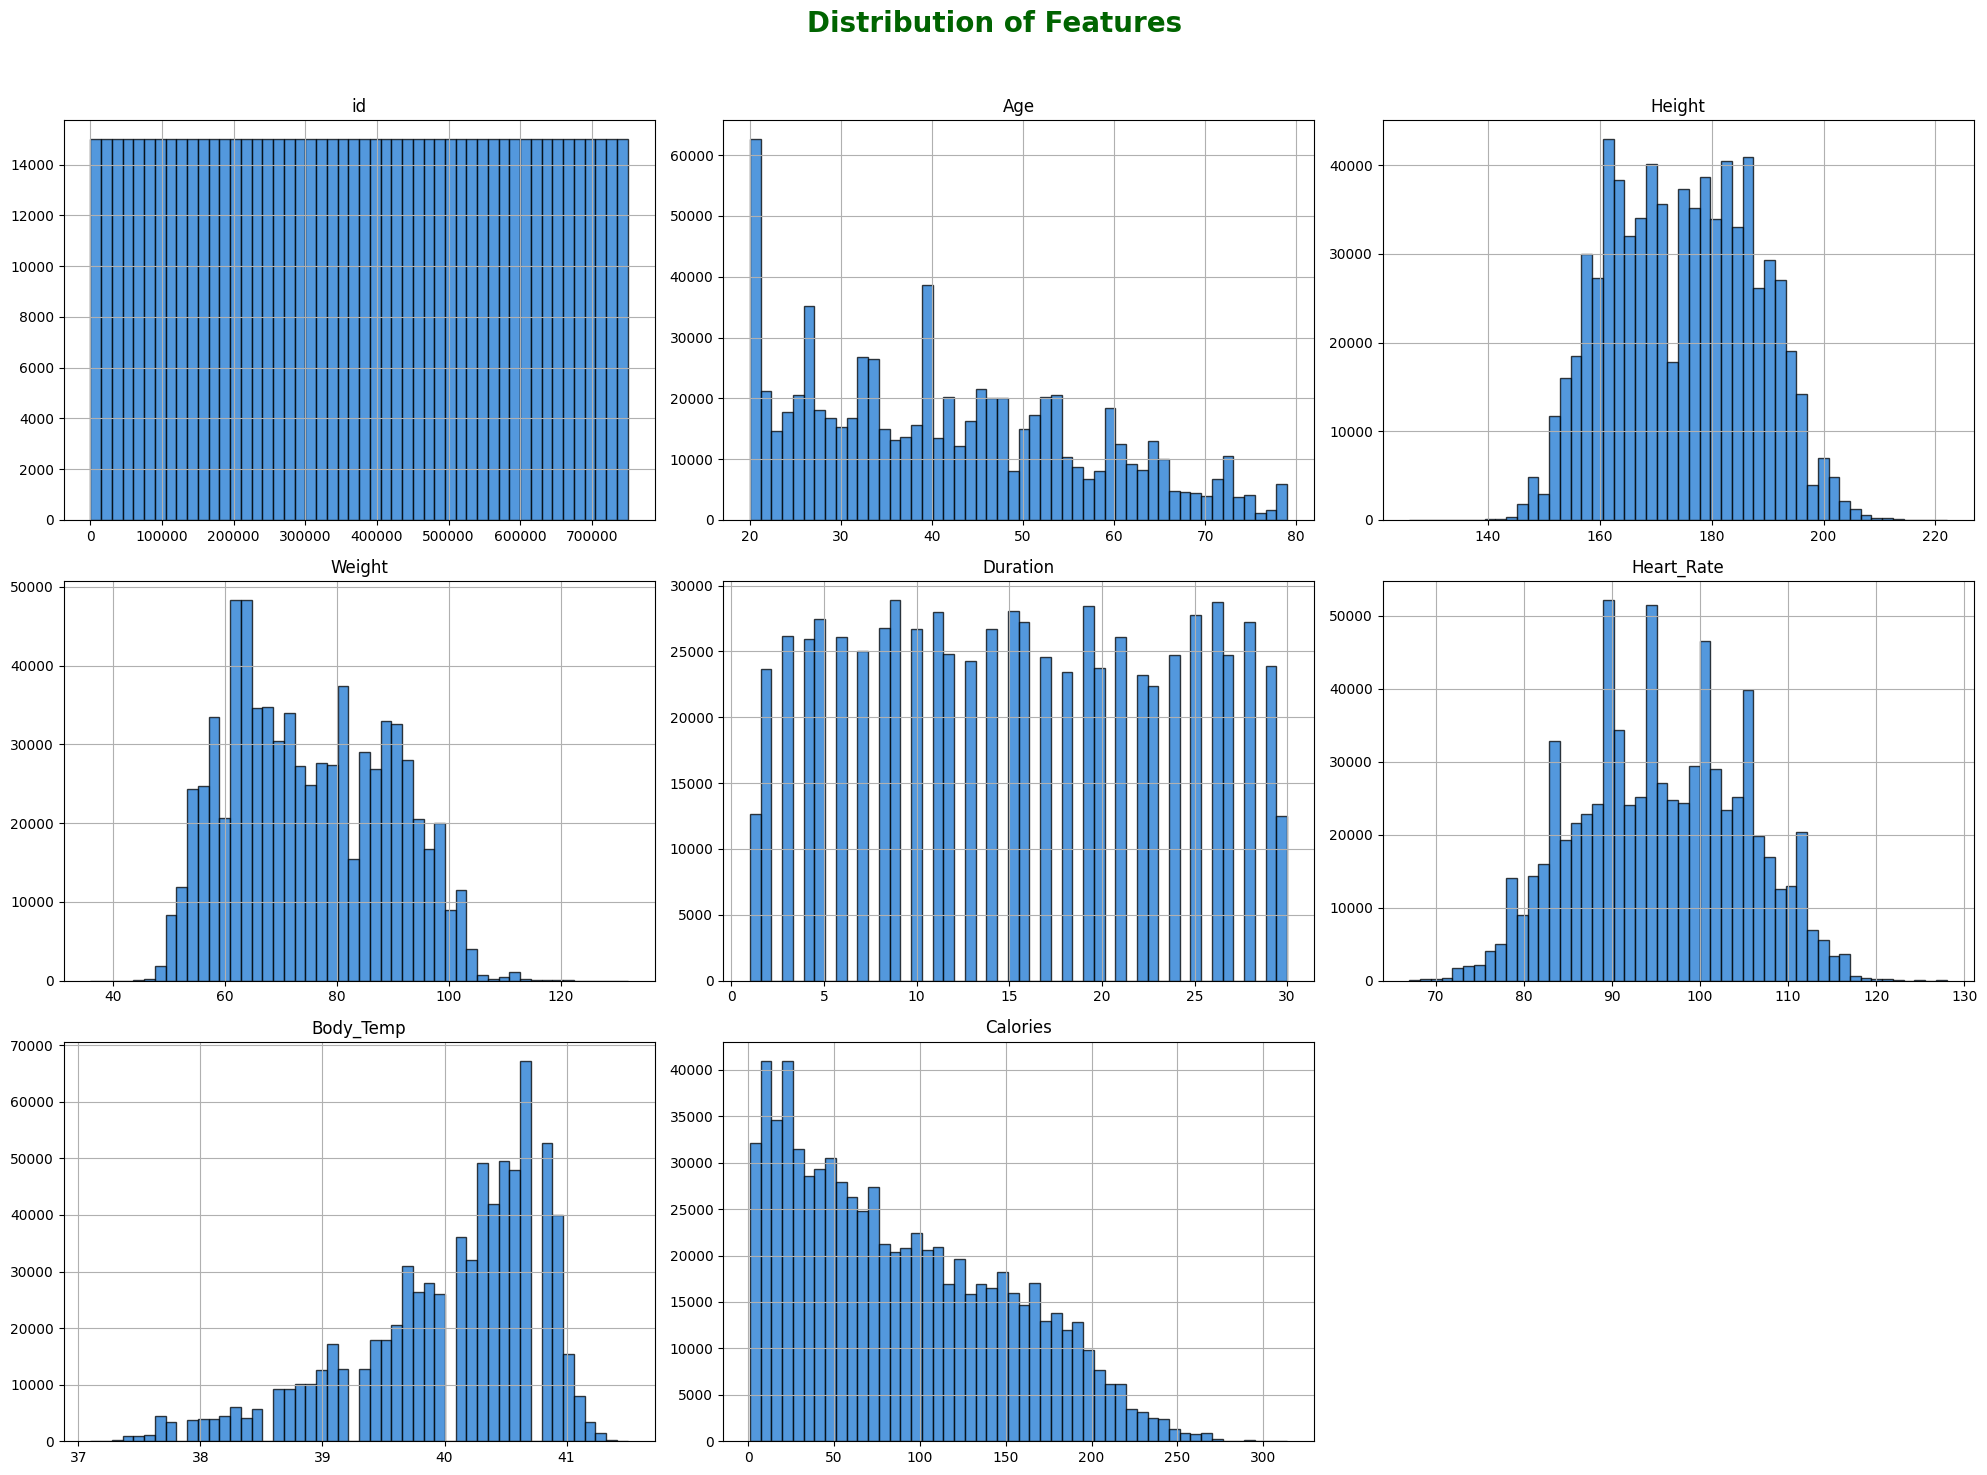

In [6]:
train.isna().sum()

In [12]:
#Checking for missing values, no missing value present
train.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [18]:
#Checking for the outlier
def outlier(df):
    outlier_col = []
    for col in df.select_dtypes(include='number').columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Check if any value in the column is an outlier
        if ((df[col] < lower_bound) | (df[col] > upper_bound)).any():
            outlier_col.append(col)
    return outlier_col

outlier_col = outlier(train)
print(f"These are the columns which has outlier values {outlier_col}")

#First iteration we will run with the outliers, in next we will check how we can handle the outliers

These are the columns which has outlier values ['Height', 'Weight', 'Heart_Rate', 'Body_Temp', 'Calories']


In [11]:
#Separating categorical and numberical columns for the pipleline,
def seperate_col(df):
    num_col = [col for col in df.columns if df[col].dtype != object]
    cat_col = [col for col in df.columns if df[col].dtype  == object]
    return num_col, cat_col

num_col,cat_col = seperate_col(train)
print(f"These are the numberical columns in the dataframe: {num_col}")
print(f"These are the categorical columns in the dataframe: {cat_col}")


These are the numberical columns in the dataframe: ['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
These are the categorical columns in the dataframe: ['Sex']


In [42]:
X = train.drop(columns='Calories')
y  = train['Calories']

In [44]:
#Creating pipeline for numerical values

# Numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])



In [45]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
])

In [46]:
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', DecisionTreeRegressor())
])


In [ ]:
# 1. Train-test split
X = train[num_col + cat_col]
y = train['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Fit pipeline
model_pipeline.fit(X_train, y_train)

# 3. Predict
y_pred = model_pipeline.predict(X_test)

# 4. Evaluate with MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")